# ANN Model
By Josh Houlding

ANN models strive to learn relationships through different sets of data. With this information, ANN models can be used to predict outcomes. 

In this assignment, students will build an ANN, then write a comprehensive technical report as a Python Jupyter notebook (to include all code, code comments, all outputs, plots, and analysis). Make sure the project documentation contains a) problem statement, b) algorithm of the solution, c) analysis of the findings, and d) references.

# Part 1

Download the "NFL Players Dataset," located in the topic Resources. The dataset contains football players' characteristics.

1. Select from a pool of 200 "Active Players" and 200 "Retired Players." 
2. Define "optimal team" based on your decision of the player characteristics necessary to build a team:
    - Starting offense (11 players): passing, rushing, and receiving.
    - Starting special teams (11 players): punting, punt returns, and kick returns.
    - Starting defense (11 players): tackles, sacks, safeties, and fumbles.
3. Your task is to identify the optimal team from each pool comprised of 33 "Active Player" and "Retired Player" members. 
4. Examine the multilayer neural network MLP architecture depicted in the "DSC-550 An Artificial Neural Network Model Image."
5. Build a deep artificial neural network MLP to include the following: a) 1 input layer, b) as many hidden layers as you deem necessary, and c) an output layer fully connected to the hidden layers.
6. Explain your architecture and how the NFL player characteristics are used as inputs.

# Part 2

Activate the MLP by performing the following steps:

1. Starting at the input layer, forward propagate the patterns of the training data through the network to generate an output.
2. Based on the network's output, calculate the error that we want to minimize using a cost function that we will describe later.
3. Back propagate the error, find its derivative with respect to each weight in the network, and update the model.
4. Repeat steps 1 through 3 for multiple epochs and learn the weights of the MLP.
5. Use forward propagation to calculate the network output and apply a threshold function to obtain the predicted class labels in the one-hot representation.
6. Interpret the output of your MLP in the context of selecting an optimal football team.

<hr>

# Part 1

<i>Download the "NFL Players Dataset," located in the topic Resources. The dataset contains football players' characteristics.</i>

In [96]:
import pandas as pd

# Load all relevant files
combine_df = pd.read_csv("nfl/combine.csv")
passer_df = pd.read_csv("nfl/passer.csv")
receiver_df = pd.read_csv("nfl/receiver.csv")
rusher_df = pd.read_csv("nfl/rusher.csv")
tackles_df = pd.read_csv("nfl/tackles.csv")
sacks_df = pd.read_csv("nfl/sacks.csv")
interceptions_df = pd.read_csv("nfl/interceptions.csv")
fumbles_df = pd.read_csv("nfl/fumbles.csv")
game_participation_df = pd.read_csv("nfl/gameParticipation.csv")

`combine.csv` has all the data from `players.csv` plus more, so we will use that file as a starting point and merge additional data. The following data files will need to be merged (and possibly aggregated beforehand): `passer.csv`, `receiver.csv`, `rusher.csv`, `tackles.csv`, `sacks.csv`, `interceptions.csv`, `fumbles.csv`, and `gameParticipation.csv`. All of these provide valuable information about the performance metrics for each player that will help our model determine which player is best for each role. 

### Aggregating performance-related dataframes
This includes `passer_df`, `receiver_df`, `rusher_df`, `tackles_df`, `sacks_df`, `interceptions_df`, and `fumbles_df`. The data in these dataframes needs to be aggregated because each contains more than one entry per player, and we need exactly one entry per player so they can all be merged together into the final dataframe used for modeling.

In [97]:
# Aggregate passer data
passer_agg = passer_df.groupby("playerId").agg({
    "passAtt": "sum", 
    "passComp": "sum", 
    "passLength": "sum", 
    "passTd": "sum", 
    "passInt": "sum", 
    "passSack": "sum", 
    "passSackYds": "sum", 
    "passHit": "sum", 
    "passDef": "sum"
}).reset_index()

# Aggregate receiver data
receiver_agg = receiver_df.groupby("playerId").agg({
    "recYards": "sum", 
    'recYards': "sum",
    'rec': "sum",
    'recYac': "sum",
    'rec1down': "sum",
    'recFumble': "sum",
    'recPassDef': "sum",
    'recPassInt': "sum"
}).reset_index()

# Aggregate rusher data
rusher_agg = rusher_df.groupby("playerId").agg({
    "rushYards": "sum", 
    "rushPrimary": "sum", 
    "rushTd": "sum"
}).reset_index()

# Aggregate tackle data
tackles_agg = tackles_df.groupby("playerId").agg({
    "tackleYdsScrim": "sum"
}).reset_index()

# Aggregate sack data
sacks_agg = sacks_df.groupby("playerId").agg({
    "sackYards": "sum"
}).reset_index()

# Aggregate interception data
interceptions_agg = interceptions_df.groupby("playerId").agg({
    "int": "sum",
    "intYards": "sum", 
    "intTd": "sum"
}).reset_index()

# Aggregate fumble data
fumbles_agg = fumbles_df.groupby("playerId").agg({
    "fumOOB": "sum",
    "fumTurnover": "sum"
})

### Aggregating `game_participation_df`
This dataframe contains several useful pieces of information not contained in the other dataframes, including `gamePartUnit` (whether the player participated in offense, defense or special teams) and `gamePartSnapCount` (the number of snap the player participated in during that game). Thus, it is in our best interest to aggregate it so it can be merged with `combine_df` into an overall dataframe. 

In [98]:
# Aggregate game participation data
game_participation_agg = game_participation_df.groupby("playerId").agg({
    "gamePartSnapCount": "sum",
    "gameId": "nunique",
    "gamePartUnit": lambda x: ",".join(x.unique())
}).reset_index()

### Merging all relevant dataframes into one overall dataframe for modeling

In [99]:
# Create copy of combine_df for overall dataframe
df = combine_df.copy()

# Select dataframes that need to be merged to combine_df
dfs_to_merge = [passer_agg, receiver_agg, rusher_agg, tackles_agg, sacks_agg, interceptions_agg, 
                fumbles_agg, game_participation_agg]

# Merge dataframes
for dataframe in dfs_to_merge:
    df = pd.merge(df, dataframe, on="playerId", how="left")

In [100]:
# Show final merged dataframe
print(f"Dataframe shape: {df.shape}")
print()
print(f"Dataframe sample: \n {df.sample(5, random_state=42)}")

Dataframe shape: (10080, 64)

Dataframe sample: 
       combineId  playerId  combineYear combinePosition  combineHeight  \
9823      20243  20190163         2019               P           73.0   
33        10033  19870053         1987              CB           70.6   
1369      11369  19910851         1991             OLB           72.8   
3620      13620  19970183         1997              WR           70.4   
3272      13272  19960855         1996              QB           73.8   

      combineWeight  combineHand nameFirst nameLast         nameFull  ...  \
9823            200          NaN      Jake   Bailey      Jake Bailey  ...   
33              163         9.50       Lou    Brock        Lou Brock  ...   
1369            223         9.63   Spencer  Hammond  Spencer Hammond  ...   
3620            187         9.25    Robert     Tate      Robert Tate  ...   
3272            211         9.63     James   Richey     James Richey  ...   

     tackleYdsScrim  sackYards  int intYards  in

This merged dataframe should contain all the data we need for the artificial neural network (ANN) to determine the optimal NFL team, but there are quite a few missing values that will need to be explored further and dealt with.

### Handling duplicate players
Let's check how many duplicate players there are: 

In [101]:
# Get total entry count and count of unique players
print(f"Total entries: {len(df)}")
unique_player_count = len(df["playerId"].unique())
print(f"Unique players: {unique_player_count}")

Total entries: 10080
Unique players: 10078


There are only a couple of duplicate players. Let's remove these:

In [102]:
# Drop duplicate players
df.drop_duplicates(subset="playerId", keep="first", inplace=True)

In [103]:
# Check for duplicates again
print(f"Total entries: {len(df)}")
unique_player_count = len(df["playerId"].unique())
print(f"Unique players: {unique_player_count}")

Total entries: 10078
Unique players: 10078


### Handling missing values

In [104]:
# Check null counts
print(f"Total entries: {len(df)}")

# Find missing value count by column
missing_values = df.isnull().sum().to_frame().reset_index()
missing_values.rename(columns={"index": "column", 0: "missing_count"}, inplace=True)
missing_values.sort_values(by="missing_count", ascending=False).transpose()

Total entries: 10078


,34,36,40,43,42,41,37,39,38,35,...,11,9,8,7,3,2,1,4,5,0
column,combineWonderlic,passComp,passSack,passDef,passHit,passSackYds,passLength,passInt,passTd,passAtt,...,collegeId,nameFull,nameLast,nameFirst,combinePosition,combineYear,playerId,combineHeight,combineWeight,combineId
missing_count,9713,9604,9604,9604,9604,9604,9604,9604,9604,9604,...,2,2,2,2,0,0,0,0,0,0


Some of the columns have almost 10,000 missing values, which seems problematic when there are only 10,080 entries in the entire dataframe. However, it is important to note that not every player performs every action in football. Quarterbacks have passing stats, running backs have rushing stats, and wide receivers have receiving stats, to name 3 examples, but each of these types of players is likely to be missing data for an action usually performed by another position, eg. the quarterback will not have data available on receiving.

# Task 1.1
<i>Select from a pool of 200 "Active Players" and 200 "Retired Players."</i>

There is no field in any of the dataset's CSV files that indicates whether a player is active or not, nor is there any information about the dates of each game in `gameParticipation.csv`. However, DOB is available for each player, so the following criterion will be used to mark whether a player is active or retired:

* <b>At most 40 years old:</b> Active.
* <b>Over 40 years old:</b> Retired.

The dataset was uploaded to Kaggle in 2020 and the tagline says the data is from 2004-present, so we will use 2020 as the current year for this assignment. Thus, any player born before 1980 will be considered retired.

### Determining if players are active or retired

First, we need to add a column for each player's age based on their DOB. Then, we will use their age to determine if they are active or not.

In [105]:
# Define cutoff age
cutoff_age = 40

# Convert date of birth column to datetime
df["dob"] = pd.to_datetime(df["dob"])

# Add column for player age
df["age"] = 2020 - df["dob"].dt.year

# Mark players over 40 as retired and the rest as active
df["status"] = df["age"].apply(lambda x: "retired" if x > cutoff_age else "active")

# Show sample data
df[["dob", "age", "status"]].sample(3, random_state=42)

,dob,age,status
9823,1997-06-18,23.0,active
33,1964-05-08,56.0,retired
1369,NaT,NaN,active


In [106]:
# Show null count for player ages
print(f"Total players: {len(df)}")
null_dob_count = df["age"].isnull().sum()
print(f"Players without available DOB: {null_dob_count}")

Total players: 10078
Players without available DOB: 1589


There are quite a few players without DOB listed, and thus their ages are unknown and their statuses cannot be determined. For simplicity, we will drop these players.

In [107]:
# Remove players with missing birthdays
df.dropna(subset=["dob"], inplace=True)

# Show updated counts
print(f"Total players: {len(df)}")
null_dob_count = df["age"].isnull().sum()
print(f"Players without available DOB: {null_dob_count}")

Total players: 8489
Players without available DOB: 0


### Selecting 200 active and 200 retired players

In [108]:
# Filter data down to active and retired players
active_players = df[df["status"] == "active"]
retired_players = df[df["status"] == "retired"]

# Take 200 random samples of each player status
active_sample = active_players.sample(200, random_state=42)
retired_sample = retired_players.sample(200, random_state=42)

In [109]:
# Show sub-sample of active players
active_sample.sample(3, random_state=42)

,combineId,playerId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nameFirst,nameLast,nameFull,...,int,intYards,intTd,fumOOB,fumTurnover,gamePartSnapCount,gameId,gamePartUnit,age,status
9387,19807,20170726,2017,OL,78.75,332,NaN,Javarius,Leamon,Javarius Leamon,...,NaN,NaN,NaN,NaN,NaN,41.0,3.0,offense,27.0,active
9355,19775,20170798,2017,SS,70.50,204,NaN,Lorenzo,Jerome,Lorenzo Jerome,...,NaN,NaN,NaN,NaN,NaN,607.0,8.0,"defense,special teams",25.0,active
6172,16173,20060141,2006,OT,78.38,315,NaN,Jonathan,Scott,Jonathan Scott,...,NaN,NaN,NaN,NaN,NaN,9.0,1.0,offense,37.0,active


In [110]:
# Show sub-sample of retired players
retired_sample.sample(3, random_state=42)

,combineId,playerId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nameFirst,nameLast,nameFull,...,int,intYards,intTd,fumOOB,fumTurnover,gamePartSnapCount,gameId,gamePartUnit,age,status
4644,14644,20010162,2001,WR,71.6,180,NaN,Jonathan,Carter,Jonathan Carter,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,41.0,retired
771,10771,19890165,1989,RB,71.4,205,NaN,Eric,Mitchel,Eric Mitchel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,retired
4045,14045,19990070,1999,DT,75.8,279,NaN,Jared,DeVries,Jared DeVries,...,1.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,44.0,retired


# Task 1.2
2. <i>Define "optimal team" based on your decision of the player characteristics necessary to build a team:</i>
    - Starting offense (11 players): passing, rushing, and receiving.
    - Starting special teams (11 players): punting, punt returns, and kick returns.
    - Starting defense (11 players): tackles, sacks, safeties, and fumbles.
    
Each part of the team contains several types of positions whose performances are judged by different metrics:

### Starting Offense (11 players)
1. Quarterback (1):
    - Passing Yards (`passLength`)
    - Touchdowns (`passTd`)
    - Completion Percentage (calculated from `passComp` and `passAtt`)
    - Interceptions (lower is better) (`passInt`)
2. Running Backs (2):
    - Rushing Yards (`rushYards`)
    - Touchdowns (`rushTd`)
    - Yards per Carry (calculated from `rushYards` and `rushPrimary`)
    - Fumbles (lower is better) (`recFumble`)
3. Wide Receivers (3): 
    - Receiving Yards (`recYards`)
    - Touchdowns (`recYards` can be used as a proxy)
    - Receptions (`rec`)
    - Yards per Reception (calculated from `recYards` and `rec`)
4. Tight End (1): 
    - Receiving Yards (`recYards`)
    - Touchdowns (`recYards` can be used as a proxy)
    - Receptions (`rec`)
    - Blocking Efficiency (if available) (not available in our data)
5. Offensive Line (4): 
    - Sacks Allowed (lower is better) (not available in our data)
    - Run Blocking Grades (if available) (not available in our data)
    - Pass Blocking Grades (if available) (not available in our data)

### Starting Special Teams (11 players)
1. Punter (1): 
    - Punt Average (not available in our data)
    - Inside 20 Yards (not available in our data)
    - Touchbacks (lower is better) (not available in our data)
2. Kick Returner (1): 
    - Return Yards (not available in our data)
    - Touchdowns (not available in our data)
    - Average Yards per Return (not available in our data)
3. Punt Returner (1): 
    - Return Yards (not available in our data)
    - Touchdowns (not available in our data)
    - Average Yards per Return (not available in our data)
4. Special Teams Players (8): 
    - Tackles on Special Teams (not available in our data)
    - Blocks(not available in our data)
    - Overall Special Teams Grades (if available) (not available in our data)
    
### Starting Defense (11 players)
1. Defensive Line (4): 
    - Sacks (`sackYards` can be used)
    - Tackles for Loss (not available in our data)
    - QB Hits (not available in our data)
    - Fumble Recoveries (not available in our data)
2. Linebackers (3): 
    - Tackles (not available in our data)
    - Sacks (`sackYards` can be used)
    - Interceptions (`int`)
    - Forced Fumbles (not available in our data)
3. Defensive Backs (4): 
    - Interceptions (`int`)
    - Pass Deflections (`passDef`)
    - Tackles (not available in our data)
    - Forced Fumbles (not available in our data)

The ideal team will be comprised of players who each maximize the positive metrics associated with their positions while minimizing the negative ones. 

Some of these features need to be calculated, so let's handle that now.

In [111]:
# Calculate completion percentage (quarterbacks)
df["completion_percentage"] = df["passComp"] / df["passAtt"]

# Calculate yards per carry (running backs)
df["yards_per_carry"] = df["rushYards"] / df["rushPrimary"]

# Calculate yards per reception (wide receivers and tight ends)
df["yards_per_reception"] = df["recYards"] / df["rec"]

In [112]:
# Show sample values
df[["playerId", "completion_percentage", "yards_per_carry", "yards_per_reception"]].sample(3, random_state=42)

,playerId,completion_percentage,yards_per_carry,yards_per_reception
2660,19940081,NaN,NaN,NaN
7099,20100239,0.66129,-1.0,NaN
7194,20100232,NaN,NaN,NaN


Again, many of these calculated features will be null because the features that went into them were null, which is because not every feature is relevant to every position.

# Tasks 1.3 and 1.4
<b>1.3:</b><i> Your task is to identify the optimal team from each pool comprised of 33 "Active Player" and "Retired Player" members.</i>

<b>1.4:</b><i> Examine the multilayer neural network MLP architecture depicted in the "DSC-550 An Artificial Neural Network Model Image."</i>

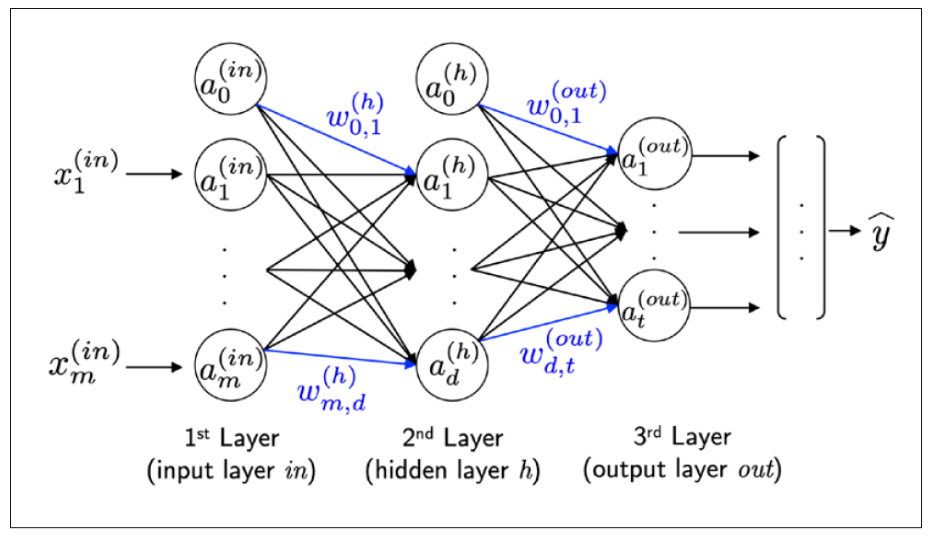

In [113]:
from IPython.display import Image

# Display ensemble method diagram
Image("ANN Model Image.png")

Our inputs will be the players, our hidden layers will be decided later when the neural network is constructed, and the outputs will be the two optimal 33-man NFL teams, one comprised of only active players and the other only of retired players.

# Tasks 1.5, 1.6 and 2.1
<b>1.5:</b><i> Build a deep artificial neural network MLP to include the following: a) 1 input layer, b) as many hidden layers as you deem necessary, and c) an output layer fully connected to the hidden layers.</i>

<b>1.6:</b><i> Explain your architecture and how the NFL player characteristics are used as inputs.</i>

<b>2.1:</b><i> Starting at the input layer, forward propagate the patterns of the training data through the network to generate an output.</i>

Now it is time to put our data to use in developing an ANN. We will execute the following procedure: 
1. Prepare features by selecting desired features, filtering the dataframe down to these features, and encoding features requiring it. 
2. Split the data into training and testing sets.
3. Standardize the data to ensure all features are on the same scale.
4. Build, train and evaluate the neural network.
5. Use the outputs of the neural network as our optimal football teams.

### Preparing relevant features

In [114]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Define relevant feature columns
feature_columns = ["age", "position", "passAtt", "passComp", "passLength", "passTd", "passInt", "completion_percentage", 
                   "rushYards", "rushPrimary", "rushTd", "yards_per_carry", "recYards", "rec", "recYac", "rec1down",
                   "recFumble", "yards_per_reception", "tackleYdsScrim", "sackYards", "int", "intYards", "intTd", "fumOOB",
                   "fumTurnover", "combine40yd", "combineVert", "combineBench", "combineShuttle", "combineBroad",
                   "combine3cone", "combine60ydShuttle"]

# Filter dataframe down to desired features
features = df[feature_columns]

# Define model target, a general performance score
# ...

We will need a general performance score for each player in order to determine how effective they are.

In [115]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convert features to dataframe
features = pd.DataFrame(features, columns=feature_columns)

# Fill infinite values with NaN and then NaN values with 0
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.fillna(0)

# Store position column before normalization
position = features["position"]

# Normalize columns
scaler = MinMaxScaler()
features = features.drop(columns=["position"])
features = scaler.fit_transform(features)

# Reassemble feature dataframe
features = pd.DataFrame(features, columns=[col for col in feature_columns if col != "position"])

# Define weights for different performance metrics (metrics where lower values are better have negative weights)
weights = {"age": 1, "passAtt": 1, "passComp": 1, "passLength": 1, "passTd": 1, "passInt": -1, "completion_percentage": 1, 
           "rushYards": 1, "rushPrimary": 1, "rushTd": 1, "yards_per_carry": 1, "recYards": 1, "rec": 1, "recYac": 1,
           "rec1down": 1, "recFumble": -1, "yards_per_reception": 1, "tackleYdsScrim": 1, "sackYards": 1, "int": 1, 
           "intYards": 1, "intTd": 1, "fumOOB": -1, "fumTurnover": -1, "combine40yd": 1, "combineVert": 1,
           "combineBench": 1, "combineShuttle": 1, "combineBroad": 1, "combine3cone": 1, "combine60ydShuttle": 1}

# Calculate performance scores
features["performance_score"] = features.apply(lambda row: sum(row[metric] * weights.get(metric, 1) for metric in features.columns), axis=1)

# Add position column back in
features = pd.concat([features, position.reset_index(drop=True)], axis=1)

# Set target to performance score
target = features["performance_score"]

In [116]:
# Show newly calculated performance scores
features[["position", "performance_score"]].head(5).transpose()

,0,1,2,3,4
position,DB,C,C,WR,DT
performance_score,6.794919,6.018686,5.970604,6.66263,5.915415


Now that we have our performance scores for each player, we can finish preparing the data, then construct, train and test the ANN model.

### Building the ANN
We will now build the ANN model with the following architecture:

* A dense input layer with 64 nodes, employing the ReLU (Rectified Linear Unit) activation function.
    + There are 64 features in the data, so having 64 nodes ensures every feature is utilized.
* Two dense hidden layers, one with 32 nodes and one with 16, both employing ReLU. 
    + Each hidden layer has less nodes than the layer before it to capture more complex and abstract patterns among the input features.
* A dense output layer with a single node and linear activation function.
    + Only one node is needed because we are dealing with a regression task involving predicting a single value for each player.

In [117]:
# Apply one-hot encoding to position column
encoder = OneHotEncoder(sparse_output=False)
features["position"] = features["position"].astype(str)
encoded_positions = encoder.fit_transform(features[["position"]])
encoded_positions_df = pd.DataFrame(encoded_positions, columns=encoder.get_feature_names_out(["position"]))

# Concatenate encoded positions with other features
features = features.drop("position", axis=1)
features = pd.concat([features, encoded_positions_df], axis=1)

# Apply train-test split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Construct the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Mean Squared Error: {mse}")

C:\Users\jdh10\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean Squared Error: 0.00016113516176119447


The model displays an extremely low MSE, so it should be highly effective at selecting the best players. Let's calculate predicted performance for each player and use that to find the optimal team.

In [118]:
# Predict performance scores
df["predicted_performance"] = model.predict(features)

266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


In [119]:
# Show performance scores for players
df[["playerId", "position", "status", "predicted_performance"]].sample(5, random_state=42)

,playerId,position,status,predicted_performance
2660,19940081,LB,retired,6.637643
7099,20100239,QB,active,6.301752
7194,20100232,DE,active,6.439315
10032,20190119,DB,active,4.991574
440,19880070,C,retired,6.163869


Now it is time to select the 33 best players for each team. This can be done by filtering the data down to active players only, sorting them by `predicted_performance` in descending order, and selecting the appropriate number of players for each position on the team, then repeating this process for the retired players.

Each team needs the following positions in these exact quantities: 
* Quarterback (1)
* Running back (2)
* Wide receiver (3)
* Tight end (1)
* Offensive line (4)
* Punter (1)
* Kick returner (1)
* Punt returner (1)
* Special teams player (8)
* Defensive line (4)
* Linebacker (3)
* Defensive back (4)

These are the position labels present in `df["position"]`:

In [120]:
# Show values of df["position"] to determine which string corresponds to each position
print("Position labels:", df["position"].unique())

Position labels: ['DB' 'C' 'WR' 'DT' 'RB' 'OT' 'TE' 'DE' 'LB' 'QB' 'OG' 'K' 'S' 'FB' 'OLB'
 'OL' 'P' 'DL' 'LS' nan]


We are assuming that quarterback is "QB", running back is "RB", wide receiver is "WR", tight end is "TE", offensive line is "OL", punter is "P", kick returner is "K", special teams player is "S", defensive line is "DE", linebacker is "LB", and defensive back is "DB". There is no label for punt returner, so we will take the second-best punter for this position instead.

In [121]:
# Filter the dataframe down to active and retired players respectively
active_players = df[df["status"] == "active"]
retired_players = df[df["status"] == "retired"]

### Finding the optimal active team

In [122]:
# Sort active players by predicted performance in descending order
active_players = active_players.sort_values(by="predicted_performance", ascending=False)

# Filter data down to relevant features
relevant_columns = ["playerId", "nameFull", "position", "predicted_performance"]
active_players = active_players[relevant_columns]

# Function to find the top n players for each position
def get_top_position_players(df, position, n): 
    return df[df["position"] == position].head(n)

# Create dataframe to store the optimal active team in
optimal_team_active = pd.DataFrame(columns=relevant_columns)

# Find optimal starting offense players
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "QB", 1)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "RB", 2)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "WR", 3)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "TE", 1)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "OL", 4)])

# Find optimal starting special teams players
punter_and_punt_returner = get_top_position_players(active_players, "P", 2)
optimal_team_active = pd.concat([optimal_team_active, punter_and_punt_returner.iloc[0:1]])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "K", 1)])
optimal_team_active = pd.concat([optimal_team_active, punter_and_punt_returner.iloc[1:2]])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "S", 8)])

# Find optimal starting defense players
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "DE", 4)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "LB", 3)])
optimal_team_active = pd.concat([optimal_team_active, get_top_position_players(active_players, "DB", 4)])

# Show optimal active team
print(f"Team size: {len(optimal_team_active)}")
print(f"Duplicate players: {optimal_team_active.duplicated().sum()}")

optimal_team_active

Team size: 33
Duplicate players: 0


,playerId,nameFull,position,predicted_performance
7961,20120075,Russell Wilson,QB,8.227610
7997,20130048,Le'Veon Bell,RB,10.082479
6370,20070012,Marshawn Lynch,RB,9.431379
7274,20100082,Emmanuel Sanders,WR,8.873080
7296,20100060,Golden Tate,WR,8.701510
7084,20100195,Antonio Brown,WR,8.414613
5645,20040032,Benjamin Watson,TE,7.913313
7384,20110138,Marcus Cannon,OL,6.624431
8831,20150059,Ty Sambrailo,OL,6.528787
8784,20150049,Mitch Morse,OL,6.480525


This is the optimal NFL team comprised of active players.

### Finding the optimal retired team

In [123]:
# Filter data down to relevant features
retired_players = retired_players[relevant_columns]

# Create dataframe to store the optimal active team in
optimal_team_retired = pd.DataFrame(columns=relevant_columns)

# Find optimal starting offense players
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "QB", 1)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "RB", 2)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "WR", 3)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "TE", 1)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "OL", 4)])

# Find optimal starting special teams players
punter_and_punt_returner = get_top_position_players(retired_players, "P", 2)
optimal_team_retired = pd.concat([optimal_team_retired, punter_and_punt_returner.iloc[0:1]])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "K", 1)])
optimal_team_retired = pd.concat([optimal_team_retired, punter_and_punt_returner.iloc[1:2]])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "S", 8)])

# Find optimal starting defense players
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "DE", 4)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "LB", 3)])
optimal_team_retired = pd.concat([optimal_team_retired, get_top_position_players(retired_players, "DB", 4)])

# Show optimal retired team
print(f"Team size: {len(optimal_team_retired)}")
print(f"Duplicate players: {optimal_team_retired.duplicated().sum()}")

optimal_team_retired

Team size: 33
Duplicate players: 0


,playerId,nameFull,position,predicted_performance
25,19870110,Steve Beuerlein,QB,5.406932
7,19870224,Joe Armentrout,RB,6.796946
16,19870143,Steve Bartalo,RB,6.628869
4,19870801,Lyneal Alston,WR,6.654113
11,19870083,Stephen Baker,WR,6.480316
14,19870114,Roy Banks,WR,6.459214
10,19870062,Robert Awalt,TE,6.423102
382,19880264,Brian Habib,OL,6.329853
571,19880094,Dave Widell,OL,5.848831
1881,19920244,Jay Leeuwenburg,OL,5.778121


Thus, we have found the optimal retired team as well.

# Task 2.2
<i>Based on the network's output, calculate the error that we want to minimize using a cost function that we will describe later.</i>

The error we want to minimize from the ANN is the mean squared error (MSE), calculated from the differences between the predicted performance and actual performance of each player. MSE is calculated using the following formula:

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$,
where $y_i$ is the $i$th player's actual performance rating, and $\hat{y}_i$ is the $i$th player's predicted performance rating by the ANN.

The MSE calculated earlier after 50 epochs was very small:

In [124]:
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00016113516176119447


This means the model was highly accurate at predicting how well a player would perform in a certain position.

# Task 2.3
<i>Back propagate the error, find its derivative with respect to each weight in the network, and update the model.</i>

The ANN was built and trained using the following code:

In [125]:
"""
# Construct the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
""";

Backpropagation is automatically performed by TensorFlow through the `fit` method. The following procedure is performed during each epoch: 

1. <b>Forward pass:</b> The inputs are pushed through each layer, and weights and biases are applied. Each layer applies activation functions to the outputs, and eventually the final output is produced.
2. <b>Loss calculation:</b> The loss function is used to calculate the difference between the prediction and actual target value.
3. <b>Backward pass (backpropagation):</b> The model calculates the gradient of the loss with respect to the output and propagates this backward through the network, starting at the output layer and ending at the input layer. 
4. <b>Updating weights:</b> The weights and biases are updated according to the computed gradient. These updates are affected by the learning rate and specific algorithm employed by the optimizer.

# Task 2.4
<i>Repeat steps 1 through 3 for multiple epochs and learn the weights of the MLP.</i>

The following code prints the weights of the neural network.

In [126]:
# Get weights for each layer
weights = model.get_weights()

# Print the weights and biases for each layer
for i, weight in enumerate(weights):
    print(f"Layer {i+1} weights and biases:")
    print(weight)

Layer 1 weights and biases:
[[ 0.10791263 -0.11166793  0.19243194 ... -0.08394465 -0.05833316
  -0.06283175]
 [ 0.10957924 -0.22078486 -0.16940694 ...  0.13474932  0.18129638
  -0.14329545]
 [-0.00483246  0.15151969 -0.1259583  ... -0.19238164 -0.22446622
  -0.16241279]
 ...
 [ 0.08490603  0.13478017  0.13555744 ...  0.1612862  -0.21720973
  -0.0499775 ]
 [ 0.01805583 -0.16807885 -0.1298865  ...  0.05937767 -0.19714668
   0.29229847]
 [-0.13878994  0.00777497  0.16908844 ...  0.22034204  0.1078299
  -0.0759768 ]]
Layer 2 weights and biases:
[ 0.0328433  -0.03153051  0.03247614  0.          0.2637064   0.03052419
  0.00184031 -0.03538732  0.02819627  0.01316529  0.02766686 -0.01993771
 -0.02157724 -0.01912044 -0.00422852  0.03047007 -0.00907813  0.01966785
 -0.00771281  0.02350657 -0.01385856 -0.03075346  0.         -0.01191116
 -0.00775678  0.          0.01880149  0.01700885  0.03294697  0.02249399
  0.03386337  0.          0.01530033  0.          0.15680367 -0.02382887
  0.          0

The original model architecture only includes 4 layers (2 hidden layers), but this output contains 6 hidden layers because TensorFlow automatically adds layers for tasks like batch normalization and dropout regularization.

# Task 2.5
<i>Use forward propagation to calculate the network output and apply a threshold function to obtain the predicted class labels in the one-hot representation.</i>

Our model has applied forward propagation by passing data through the input layer, processing it in the hidden layers with activation functions, then receiving an output from the output layer. The threshold function is then applied to this output, and in our case, it selected the top n players for each position on the team based on their performance scores, where n is the number of players needed for that position on a 33-man team.

# Task 2.6
<i>Interpret the output of your MLP in the context of selecting an optimal football team.</i>

The original objective of the model was to select two optimal football teams, one made up of active players and the other made up of retired players. This was done by selecting relevant metrics to judge player performance on, applying weights to each metric according to its importance and sign (metrics where lower values are better must have a negative weight applied), calculating performance scores for each player using forward propagation through the MLP, grouping players by their positions, and then choosing the best players for each position based on their performance scores. 

Thus, the two 33-man teams I have constructed are what I believe to be the optimal active and retired teams. These are the teams again:

In [127]:
# Display optimal active team
optimal_active_players = optimal_team_active["nameFull"].unique()
print(f"Optimal active team: {optimal_active_players}\n")

# Display optimal retired team
optimal_retired_players = optimal_team_retired["nameFull"].unique()
print(f"Optimal retired team: {optimal_retired_players}")

Optimal active team: ['Russell Wilson' "Le'Veon Bell" 'Marshawn Lynch' 'Emmanuel Sanders'
 'Golden Tate' 'Antonio Brown' 'Benjamin Watson' 'Marcus Cannon'
 'Ty Sambrailo' 'Mitch Morse' 'Bruce Campbell' 'JK Scott' 'Dustin Hopkins'
 'Trevor Daniel' 'Antoine Bethea' 'Eric Weddle' 'Harrison Smith'
 'Malcolm Jenkins' 'Tre Boston' 'Reshad Jones' 'Rashad Johnson'
 'Kerry Rhodes' 'Chauncey Davis' 'Igor Olshansky' 'Isaac Hilton'
 'Eric Coleman' 'Alec Ogletree' 'Lofa Tatupu' 'Nick Barnett'
 'Rashean Mathis' 'Devin McCourty' 'Johnathan Joseph' 'Aqib Talib']

Optimal retired team: ['Steve Beuerlein' 'Joe Armentrout' 'Steve Bartalo' 'Lyneal Alston'
 'Stephen Baker' 'Roy Banks' 'Robert Awalt' 'Brian Habib' 'Dave Widell'
 'Jay Leeuwenburg' 'Siupeli Malamala' 'Tom Tupa' 'Greg Davis'
 'Kent Elmore' 'Tony Elliott' 'Charles Glaze' 'Tim McDonald' 'Rod Woodson'
 'John Booty' 'Selwyn Brown' 'Greg Cox' 'Anthony Newman' 'Robert Banks'
 'John Bosa' 'Jason Buck' 'Donald Evans' 'Ray Berry' 'David Brandon'
 'Toby

# References
* GeeksforGeeks. (2023b, June 2). Artificial Neural Networks and its Applications. GeeksforGeeks. https://www.geeksforgeeks.org/artificial-neural-networks-and-its-applications/
* OpenAI. (2024). ChatGPT [Large language model]. https://chatgpt.com/
* Microsoft. (2024). Copilot [Large language model]. https://www.bing.com/?FORM=Z9FD1